In [ ]:
import geopandas as gpd

# Load the GeoPackage
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/KNN/data_final_normalized.gpkg")

# Print the columns
print(gdf.columns)


Index(['ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
       'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
       'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
       'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2', 'fire',
       'geometry'],
      dtype='object')


#clarans from scratch

In [ ]:
import numpy as np
import random
import geopandas as gpd
from sklearn.metrics import silhouette_score

X = gdf.drop(columns=['fire', gdf.geometry.name]).reset_index(drop=True)
X_np = X.to_numpy()
cat_index = X.columns.get_loc('GRIDCODE')

# ------------------------------
# Custom CLARANS function (as you provided)
# ------------------------------
def distance(instance, centroid, cat_index):
    num_distance = 0.0
    for i in range(len(instance)):
        if i != cat_index:
            num_distance += (instance[i] - centroid[i]) ** 2
    num_distance = num_distance ** 0.5

    cat_distance = 0 if instance[cat_index] == centroid[cat_index] else 1

    return (num_distance + cat_distance) / 2


def clarans(X, k, numlocal, maxneighbor, cat_index=0):
    n = len(X)

    global_best_cost = float('inf')
    global_best_medoids = None

    for _ in range(numlocal):
        medoids = random.sample(range(n), k)

        def total_cost(meds):
            cost = 0.0
            for i in range(n):
                dists = [distance(X[i], X[j], cat_index) for j in meds]
                cost += min(dists)
            return cost

        current_cost = total_cost(medoids)
        neighbor_count = 0

        while neighbor_count < maxneighbor:
            medoid_to_replace = random.choice(medoids)
            candidate = random.choice([i for i in range(n) if i not in medoids])

            new_medoids = medoids.copy()
            new_medoids[medoids.index(medoid_to_replace)] = candidate
            new_cost = total_cost(new_medoids)

            if new_cost < current_cost:
                medoids = new_medoids
                current_cost = new_cost
                neighbor_count = 0
            else:
                neighbor_count += 1

        if current_cost < global_best_cost:
            global_best_cost = current_cost
            global_best_medoids = medoids

    labels = np.zeros(n, dtype=int)
    for i in range(n):
        dists = [distance(X[i], X[j], cat_index) for j in global_best_medoids]
        labels[i] = np.argmin(dists)

    return labels, global_best_medoids

# ------------------------------
# Run 10 times and keep best
# ------------------------------
num_runs = 10
best_labels = None
best_score = -1

for run in range(num_runs):
    labels, medoids = clarans(X_np, k=3, numlocal=1, maxneighbor=2, cat_index=cat_index)
    try:
        score = silhouette_score(X_np, labels)
    except:
        score = -1

    if score > best_score:
        best_score = score
        best_labels = labels.copy()

# Assign best labels to GeoDataFrame
gdf['cluster'] = best_labels
print(f"Best silhouette score: {best_score:.4f}")
print(gdf['cluster'].value_counts())


Best silhouette score: 0.3229
cluster
1    5733
0    3822
2    2274
Name: count, dtype: int64


#evaluation

In [ ]:
!pip install permetrics

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


mask = gdf['cluster'] != -1
X_filtered = X[mask]
labels_filtered = gdf['cluster'][mask]

# Silhouette Score
sil_score = silhouette_score(X_filtered, labels_filtered)
print("Silhouette Score:", sil_score)

# Davies-Bouldin Index (lower is better)
db_score = davies_bouldin_score(X_filtered, labels_filtered)
print("Davies-Bouldin Index:", db_score)

# Calinski-Harabasz Index (higher is better)
ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
print("Calinski-Harabasz Index:", ch_score)


import numpy as np
from permetrics import ClusteringMetric

X_filtered = X_filtered.to_numpy()  # Convert GeoDataFrame to NumPy
labels_filtered = gdf['cluster'][mask].to_numpy()  #  cluster labels

# Create the ClusteringMetric object

cm = ClusteringMetric(X=X_filtered, y_pred=labels_filtered)

# Compute metrics
dunn = cm.dunn_index()
DI = cm.DI()  # DI is another name for Dunn Index in permetrics

print("Dunn Index:", dunn)





Silhouette Score: 0.32290516224667387
Davies-Bouldin Index: 66.78244066049552
Calinski-Harabasz Index: 8977.82969482923
Dunn Index: 0.013609081361840641


# interpretation

In [ ]:
# Number of points per cluster
cluster_size = gdf.groupby('cluster').size()

# Number of fires per cluster (fire = 1)
cluster_fires = gdf.groupby('cluster')['fire'].sum()

# Percentage of fires relative to cluster size
fire_pct_cluster = (cluster_fires / cluster_size) * 100

print(fire_pct_cluster)


cluster
0    36.865515
1     8.860980
2    31.310466
dtype: float64


In [ ]:

# Total number of fire occurrences in the dataset
total_fires = gdf['fire'].sum()  # sums all 1s

# Number of fires per cluster
cluster_fires = gdf.groupby('cluster')['fire'].sum()  # sums 1s per cluster

# Percentage of total fires in each cluster
fire_pct_total = (cluster_fires / total_fires) * 100

print(fire_pct_total)



cluster
0    53.594523
1    19.322936
2    27.082541
Name: fire, dtype: float64


In [ ]:
print(gdf['cluster'].value_counts())

cluster
1    5733
0    3822
2    2274
Name: count, dtype: int64


/tmp/ipython-input-637783513.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1')  # discrete colormap


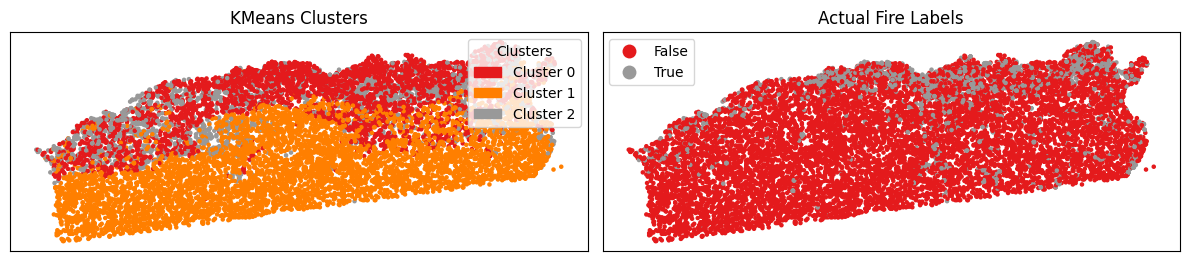

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np

# Set figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---- Plot KMeans clusters ----
cmap = cm.get_cmap('Set1')  # discrete colormap
gdf.plot(column='cluster', cmap=cmap, markersize=5, legend=False, ax=axes[0])
axes[0].set_title('KMeans Clusters')

# ---- Create colored legend that matches the map ----
cluster_ids = sorted(gdf['cluster'].unique())
# Normalize cluster IDs to [0,1] to pick the correct color from the cmap
colors = [cmap(i / (len(cluster_ids)-1)) for i in range(len(cluster_ids))]
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {cluster_ids[i]}')
           for i in range(len(cluster_ids))]
axes[0].legend(handles=patches, title='Clusters', loc='upper right')

# ---- Plot actual fire labels ----
gdf.plot(column='fire', cmap='Set1', markersize=5, legend=True, ax=axes[1])
axes[1].set_title('Actual Fire Labels')

# Remove axis ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
cluster_stats = gdf.groupby('cluster')[X.columns].mean()
print(cluster_stats)
gridcode_mode = (
    gdf.groupby('cluster')['GRIDCODE']
       .agg(lambda x: x.mode().iloc[0])
)

print(gridcode_mode)


         ALUM_SAT      CLAY  ELEC_COND    GRIDCODE  ORG_CARBON  PH_WATER  \
cluster                                                                    
0        0.086218  0.486817   0.574271   52.611460    0.410772  0.876808   
1        0.047237  0.370744   0.590861  167.349206    0.342457  0.936832   
2        0.066675  0.500517   0.559089   51.771768    0.391510  0.865095   

             SAND      SILT       TEB   TOTAL_N  ...  elevation1     ndvi1  \
cluster                                          ...                         
0        0.426699  0.702345  0.215771  0.550785  ...    0.278688  0.558391   
1        0.566312  0.594954  0.268125  0.492950  ...    0.330920  0.319751   
2        0.406733  0.667586  0.225403  0.529297  ...    0.248559  0.483969   

         precip_s1_log10  precip_s2_log10  precip_s3_log10  precip_s4_log10  \
cluster                                                                       
0               0.679602         0.600449         0.585319         0.6

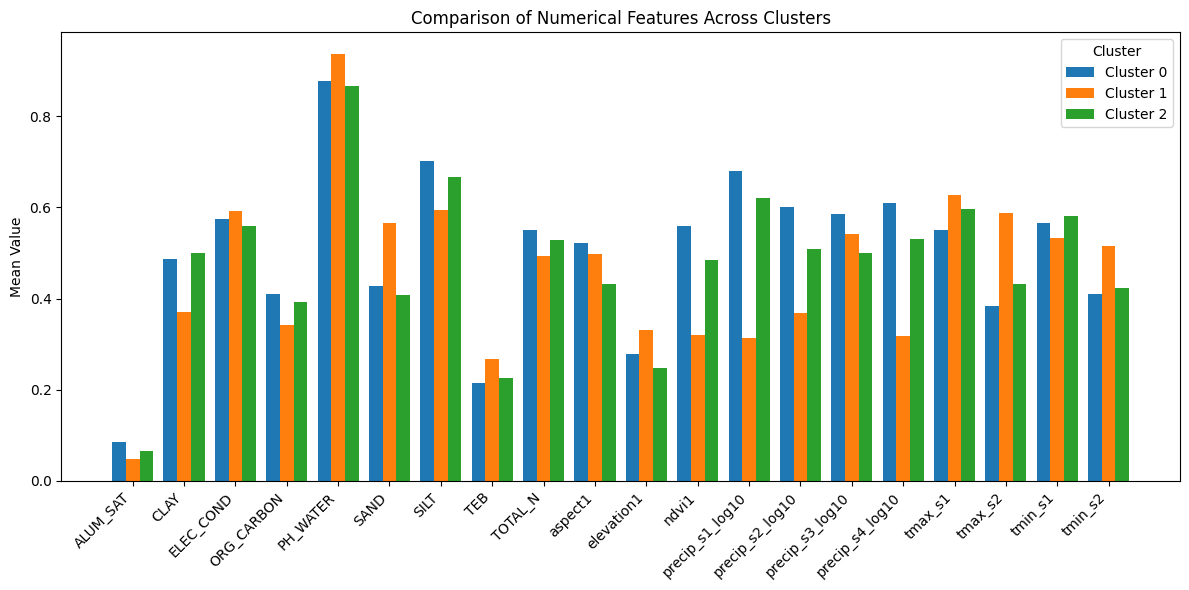

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude GRIDCODE
numerical_features = X.columns.drop('GRIDCODE', errors='ignore')

# Compute mean per cluster
cluster_stats = gdf.groupby('cluster')[numerical_features].mean()

# Plot grouped bars
clusters = cluster_stats.index
n_clusters = len(clusters)
n_features = len(numerical_features)
bar_width = 0.8 / n_clusters  # space bars for each cluster

x = np.arange(n_features)  # feature positions

fig, ax = plt.subplots(figsize=(12,6))

for i, cluster_id in enumerate(clusters):
    ax.bar(x + i*bar_width, cluster_stats.loc[cluster_id],
           width=bar_width, label=f'Cluster {cluster_id}')

ax.set_xticks(x + bar_width*(n_clusters-1)/2)
ax.set_xticklabels(numerical_features, rotation=45, ha='right')
ax.set_ylabel("Mean Value")
ax.set_title("Comparison of Numerical Features Across Clusters")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()
